# Write-Up

### Data Selection
* Data was cleaned by dropping columns where all values were null values and dropping rows with null values 
* Then, a label column was created by label-encoding the disposition column
* In order to narrow down the data selection, I looked at the correlations of each of the features to disposition values - any features with an asbolute value r greater than 0.1 was included in the dataset for the model 
* Data was then split 80-20 into training and testing sets

### Model Selection
* All models were fit on the training set
* I used the yellowbrick library and four functions from the libarary across each model, with the exception of SVM, which couldn't load the cross-validation score
* The first metric was the cross validation score chart. The function ran the model 12 different times and computed a cross-validation score based off of the f1-weighted score for each scenario. The metric tells us how consistent our model results are since it's possible that the first time we run our model we just get lucky. All of the models were consistent across the cross-validation scenarios, but some had much higher cross-validation scores. 
* The second metric was the confusion matrix, which showed the actual values vs predicted values to indicate relative numbers of false positives, false negatives, true positives, and true negatives. The darker the colors on the visualization, the closer to 100% the number is. In all models, the percent of true positives for the disposition class "FALSE POSITIVE" was much higher than the other disposition classes - this is largely due to the skew in the distribution of data points. 
* The third metric was classification report. Since the distribution of the data set was skewed with about 3/5ths of the data marked as "FALSE POSITIVE", the f1 metric within the classification report was the deciding metric. F1 is a weighted average of the precision of the model (the number of correctly predicted class points vs the number of class predictions) and the recall of the model (the number of correctly predicted class points vs the actual number of class points). 
* The fourth metric was the ROC Curve with ROC-AUC values in the legend. The function brought back individual AUC scores as well as micro and macro weighted scores. Since the distribution of the data was imbalanced, I looked at the micro-average across all three classes to compare model fit. 

* Using these four metrics, I chose the Random Forest Regressor as my preliminary model choice. I then looked at the feature importance from that model, again using yellowbrick. There was a clear difference between the first four features and the fifth, so initially I was going to only use those four features, but then I thought it would be best to select all features with importance scores over 50. 
* I then wanted to look for any collinearity between features, so I used yellowbrick's 2D Rank model to get the correlation coefficients between model features. After consulting the graph, I decided to keep the "ra" feature as well, since it had little correlation with any other feature.
* I then re-pulled data, split it, and re-ran most of the models and decidely the results were worse for all models I re-ran, so I decided to stick with my original modelling data. 


# Dependencies

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

In [42]:
# visualizations
import matplotlib.pyplot as plt
import seaborn as sn

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


# machine learning processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

#import metrics
import yellowbrick.classifier as ybc
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores

# from scikitplot.metrics import plot_roc, plot_confusion_matrix

#basic imports
import pandas as pd
import numpy as np
import os

In [3]:
from yellowbrick.style import set_palette
set_palette('dark')

# Read the CSV and Perform Basic Data Cleaning

In [4]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6991 entries, 0 to 6990
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    6991 non-null   object 
 1   koi_fpflag_nt      6991 non-null   int64  
 2   koi_fpflag_ss      6991 non-null   int64  
 3   koi_fpflag_co      6991 non-null   int64  
 4   koi_fpflag_ec      6991 non-null   int64  
 5   koi_period         6991 non-null   float64
 6   koi_period_err1    6991 non-null   float64
 7   koi_period_err2    6991 non-null   float64
 8   koi_time0bk        6991 non-null   float64
 9   koi_time0bk_err1   6991 non-null   float64
 10  koi_time0bk_err2   6991 non-null   float64
 11  koi_impact         6991 non-null   float64
 12  koi_impact_err1    6991 non-null   float64
 13  koi_impact_err2    6991 non-null   float64
 14  koi_duration       6991 non-null   float64
 15  koi_duration_err1  6991 non-null   float64
 16  koi_duration_err2  6991 

In [6]:
df.describe()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6.991000e+03,6.991000e+03,6991.000000,6991.000000,6991.000000,...,6991.000000,6991.000000,6991.000000,6991.00000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000,6991.000000
mean,0.157059,0.244743,0.202975,0.125018,56.191248,1.851122e-03,-1.851122e-03,164.488820,0.009340,-0.009340,...,-161.206980,4.305049,0.121091,-0.14048,1.740749,0.352710,-0.388568,292.082406,43.812143,14.271508
std,0.363882,0.429966,0.402243,0.330763,117.570962,7.184503e-03,7.184503e-03,67.020475,0.021989,0.021989,...,71.448481,0.439238,0.132048,0.08199,5.903415,0.839017,1.907797,4.762908,3.606167,1.350802
min,0.000000,0.000000,0.000000,0.000000,0.259820,1.100000e-08,-1.568000e-01,120.515914,0.000009,-0.569000,...,-1733.000000,0.047000,0.000000,-1.00700,0.109000,0.000000,-103.825000,279.856080,36.577381,6.966000
25%,0.000000,0.000000,0.000000,0.000000,2.620126,5.005000e-06,-2.401000e-04,132.683917,0.001145,-0.010000,...,-197.000000,4.209000,0.044000,-0.19500,0.829000,0.128000,-0.252000,288.704730,40.797760,13.455000
50%,0.000000,0.000000,0.000000,0.000000,8.947426,3.300000e-05,-3.300000e-05,136.739230,0.003990,-0.003990,...,-159.000000,4.436000,0.070000,-0.12700,0.999000,0.248000,-0.111000,292.314760,43.679661,14.534000
75%,0.000000,0.000000,0.000000,0.000000,34.282605,2.401000e-04,-5.005000e-06,169.937005,0.010000,-0.001145,...,-112.000000,4.543000,0.149000,-0.08800,1.357000,0.357000,-0.069000,295.888550,46.693659,15.322000
max,1.000000,1.000000,1.000000,1.000000,1071.232624,1.568000e-01,-1.100000e-08,1472.522306,0.569000,-0.000009,...,0.000000,5.364000,1.472000,0.00000,180.013000,25.956000,0.000000,301.720760,52.336010,19.065000


In [7]:
df.koi_disposition.value_counts()

FALSE POSITIVE    3504
CONFIRMED         1800
CANDIDATE         1687
Name: koi_disposition, dtype: int64

In [8]:
labels = {"FALSE POSITIVE":0, "CONFIRMED":1, "CANDIDATE":2}
df['label'] = [labels[x] for x in df.koi_disposition]
df.head(10)

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,label
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1
5,CONFIRMED,0,0,0,0,2.566589,1.780000e-05,-1.780000e-05,179.554370,0.004610,...,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1
6,CONFIRMED,0,0,0,0,16.068647,1.090000e-05,-1.090000e-05,173.621937,0.000517,...,4.485,0.083,-0.028,0.848,0.033,-0.072,286.99948,48.375790,15.841,1
7,CONFIRMED,0,0,0,0,2.470613,2.700000e-08,-2.700000e-08,122.763305,0.000009,...,4.457,0.024,-0.024,0.964,0.038,-0.038,286.80847,49.316399,11.338,1
8,CONFIRMED,0,1,0,0,2.204735,4.300000e-08,-4.300000e-08,121.358542,0.000016,...,4.019,0.033,-0.027,1.952,0.099,-0.110,292.24728,47.969521,10.463,1
9,CONFIRMED,0,0,0,0,3.522498,1.980000e-07,-1.980000e-07,121.119423,0.000047,...,4.169,0.055,-0.045,1.451,0.110,-0.110,281.28812,42.451080,13.563,1


In [9]:
all_features = df.corr().label
select_features = list(all_features.loc[(abs(all_features.values)>0.1) & (abs(all_features.values)!=1)].index)
select_features

['koi_fpflag_nt',
 'koi_fpflag_ss',
 'koi_fpflag_co',
 'koi_fpflag_ec',
 'koi_duration',
 'koi_depth',
 'koi_teq',
 'koi_model_snr',
 'koi_tce_plnt_num',
 'koi_steff',
 'koi_steff_err1',
 'koi_steff_err2',
 'koi_slogg',
 'koi_slogg_err2',
 'ra']

# Select your features (columns)

In [10]:
# Set features. This will also be used as your x values.
X = df[select_features]
y = df.label

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6991 entries, 0 to 6990
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_fpflag_nt     6991 non-null   int64  
 1   koi_fpflag_ss     6991 non-null   int64  
 2   koi_fpflag_co     6991 non-null   int64  
 3   koi_fpflag_ec     6991 non-null   int64  
 4   koi_duration      6991 non-null   float64
 5   koi_depth         6991 non-null   float64
 6   koi_teq           6991 non-null   int64  
 7   koi_model_snr     6991 non-null   float64
 8   koi_tce_plnt_num  6991 non-null   int64  
 9   koi_steff         6991 non-null   int64  
 10  koi_steff_err1    6991 non-null   int64  
 11  koi_steff_err2    6991 non-null   int64  
 12  koi_slogg         6991 non-null   float64
 13  koi_slogg_err2    6991 non-null   float64
 14  ra                6991 non-null   float64
dtypes: float64(6), int64(9)
memory usage: 873.9 KB


# Create a Train Test Split

Use `koi_disposition` for the y values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17, stratify=y) #stratify for unequal target weights

In [13]:
print(len(X_train))
print(len(X_test))

5243
1748


# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [14]:
# Scale your data
# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model 

In [15]:
#logistic
lrc = LogisticRegression() #init
lrc.fit(X_train_scaled, y_train) #fit
preds = lrc.predict(X_test_scaled) #predict
proba_preds = lrc.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERA

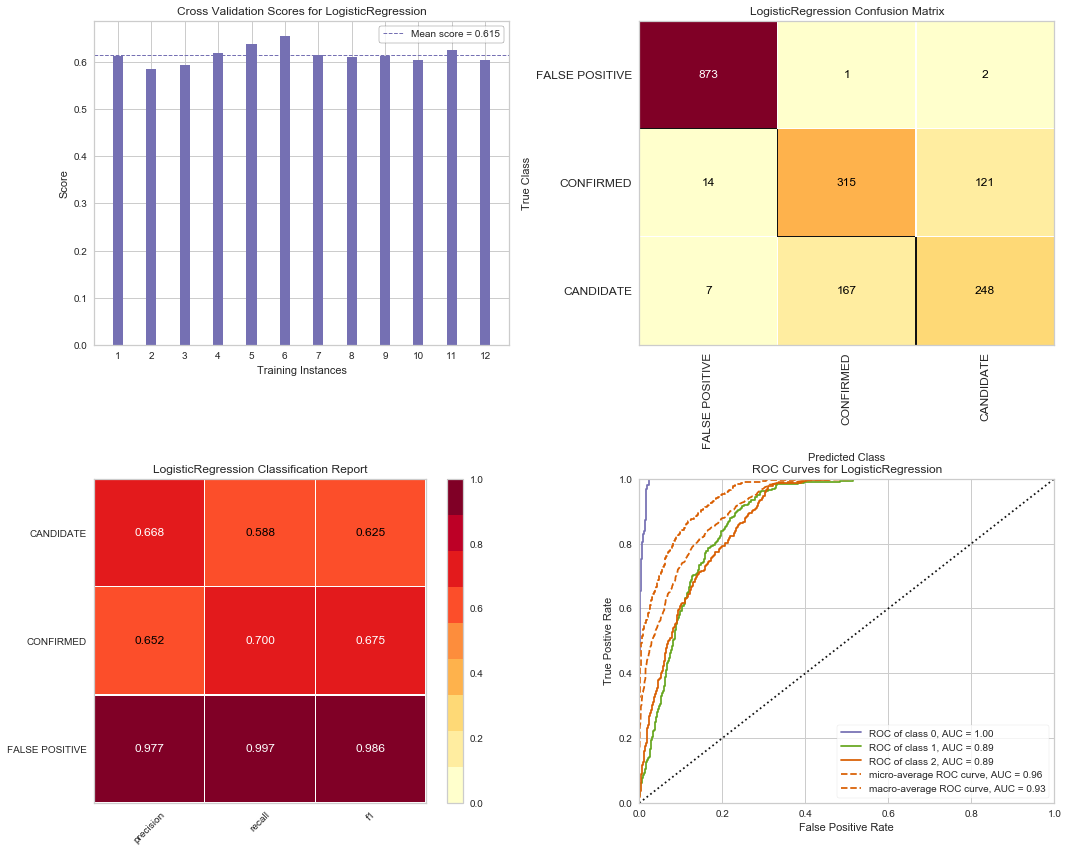

In [95]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(lrc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(lrc, classes = ["FALSE POSITIVE", "CONFIRMED", "CANDIDATE"], ax=axes[0][1]),
    ybc.ClassificationReport(lrc,classes = ["FALSE POSITIVE", "CONFIRMED", "CANDIDATE"], ax=axes[1][0]),
    ybc.ROCAUC(lrc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

#You have to scroll a bit to see the charts, but they're there, I promise

# K Neighbors Model

k: 1, Train/Test Score: 1.000/0.780
k: 3, Train/Test Score: 0.897/0.800
k: 5, Train/Test Score: 0.871/0.804
k: 7, Train/Test Score: 0.858/0.800
k: 9, Train/Test Score: 0.852/0.808
k: 11, Train/Test Score: 0.846/0.817
k: 13, Train/Test Score: 0.841/0.816
k: 15, Train/Test Score: 0.842/0.818
k: 17, Train/Test Score: 0.840/0.817
k: 19, Train/Test Score: 0.841/0.812


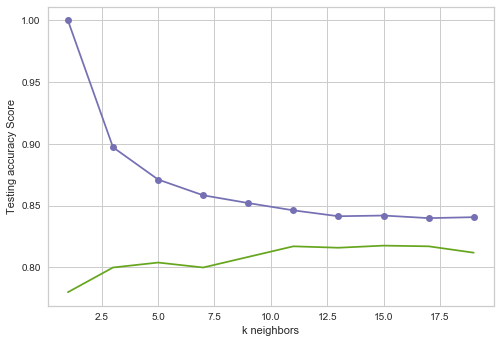

In [17]:
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
preds = knn.predict(X_test_scaled) #predict
proba_preds = knn.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


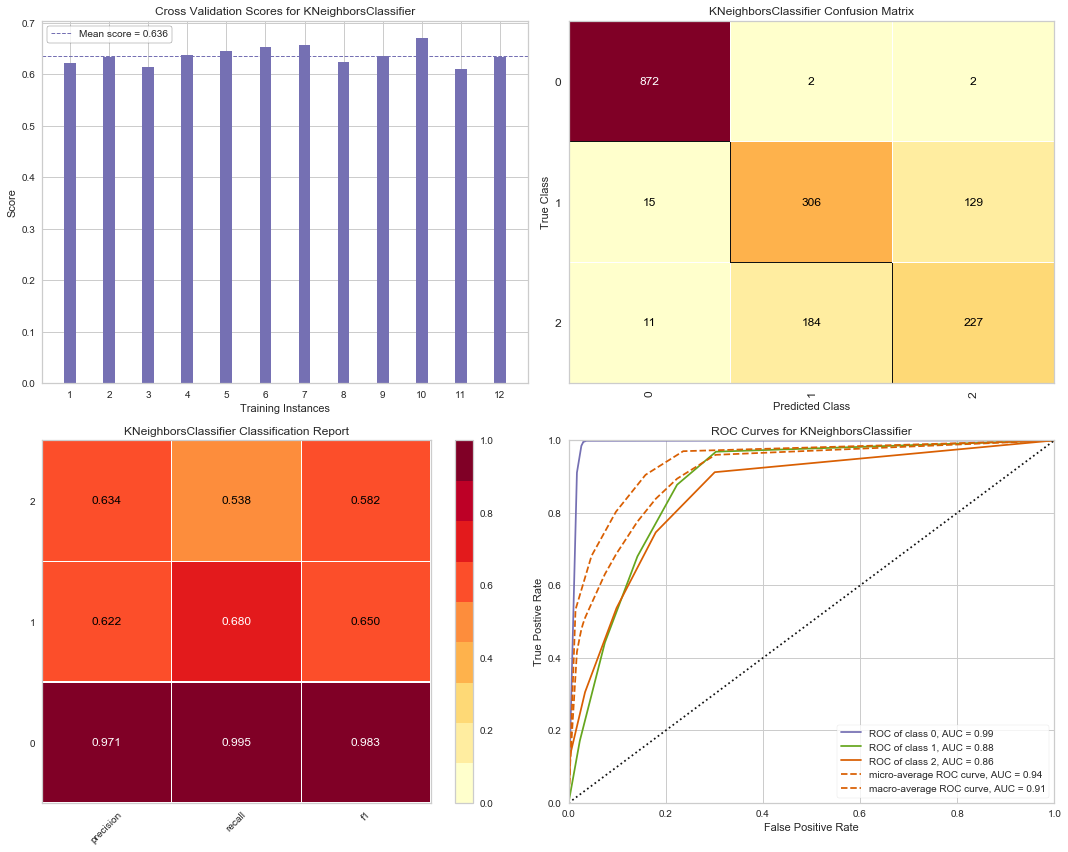

In [19]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(knn,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(knn, ax=axes[0][1]),
    ybc.ClassificationReport(knn, ax=axes[1][0]),
    ybc.ROCAUC(knn, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

# SVM Model

In [20]:
#SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_scaled, y_train)
preds = svm.predict(X_test_scaled) #predict
proba_preds = svm.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


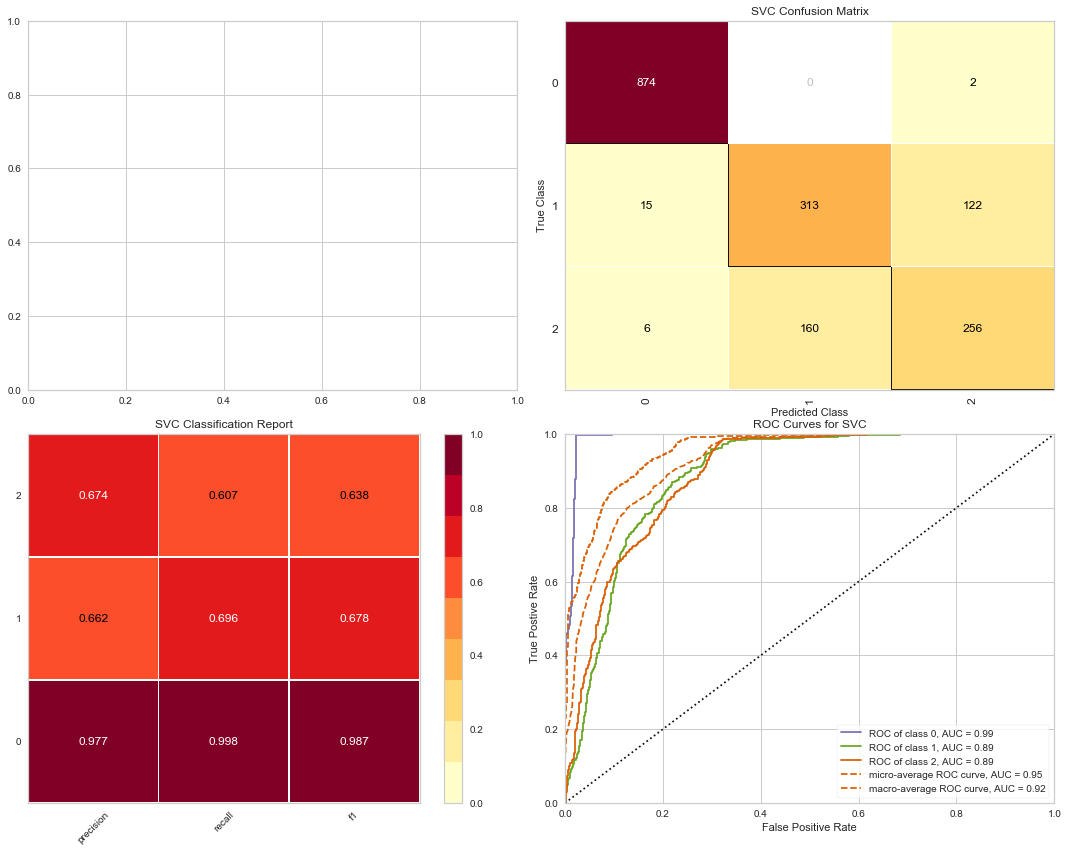

In [21]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
#     CVScores(svm,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(svm, ax=axes[0][1]),
    ybc.ClassificationReport(svm, ax=axes[1][0]),
    ybc.ROCAUC(svm, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

# Decision Tree Model

In [22]:
dtc = DecisionTreeClassifier() #init
dtc.fit(X_train_scaled, y_train) #fit
preds = dtc.predict(X_test_scaled) #predict
proba_preds = dtc.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


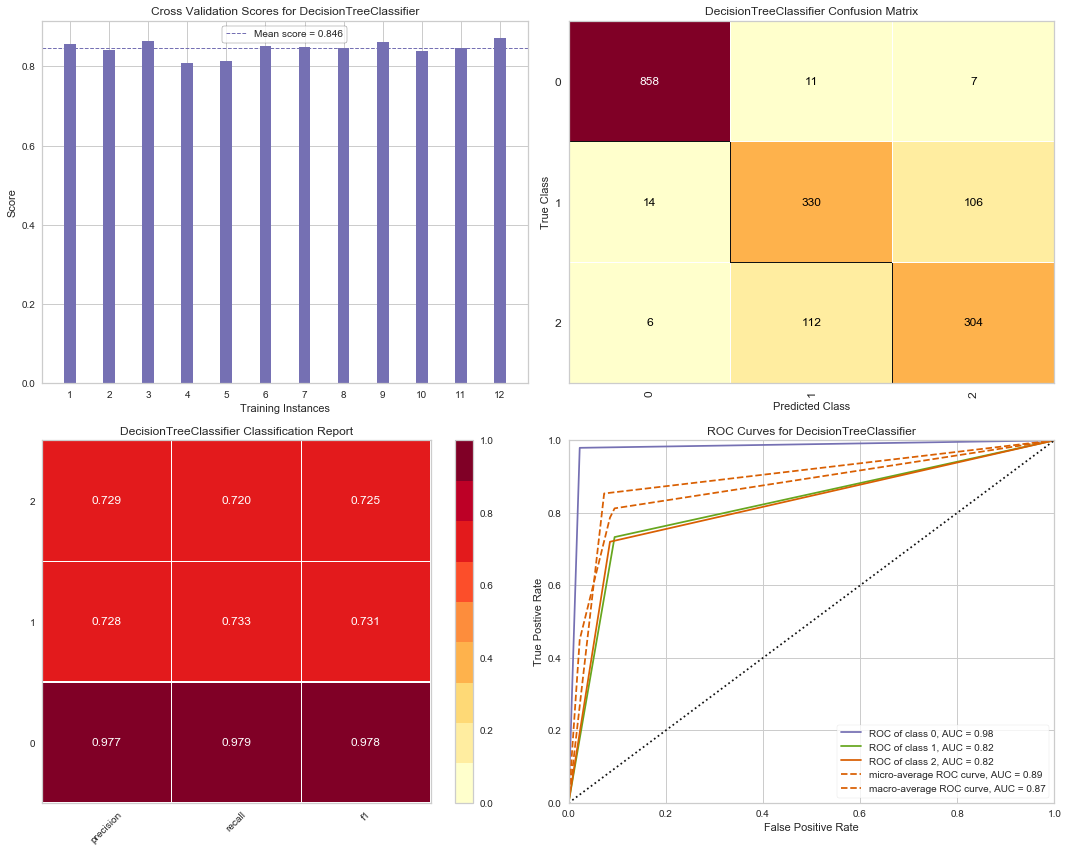

In [23]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(dtc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(dtc, ax=axes[0][1]),
    ybc.ClassificationReport(dtc, ax=axes[1][0]),
    ybc.ROCAUC(dtc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

# Bagging Classifier Model

In [26]:
bagc = BaggingClassifier() #init
bagc.fit(X_train_scaled, y_train) #fit
preds = bagc.predict(X_test_scaled) #predict
proba_preds = bagc.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


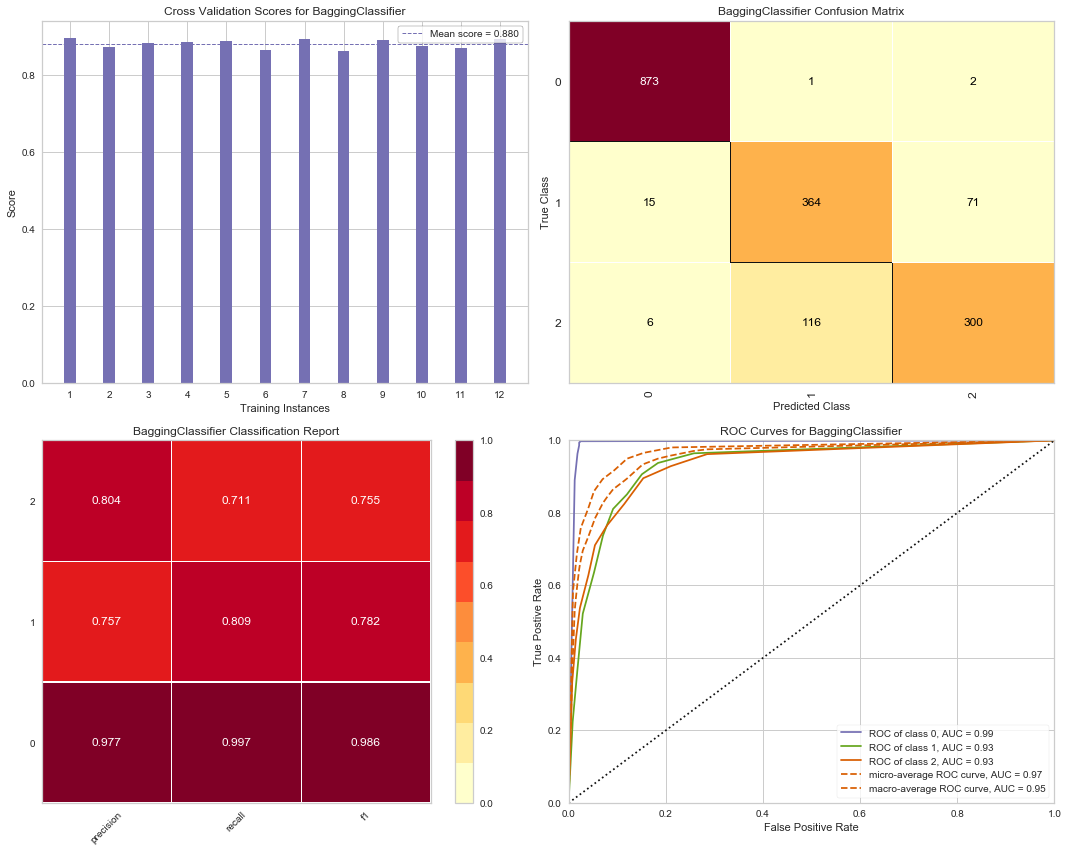

In [27]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(bagc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(bagc, ax=axes[0][1]),
    ybc.ClassificationReport(bagc, ax=axes[1][0]),
    ybc.ROCAUC(bagc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

# Ada Boost Classifier Model

In [28]:
#Ada Boost Classifier
adac = AdaBoostClassifier() #init
adac.fit(X_train_scaled, y_train) #fit
preds = adac.predict(X_test_scaled) #predict
proba_preds = adac.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


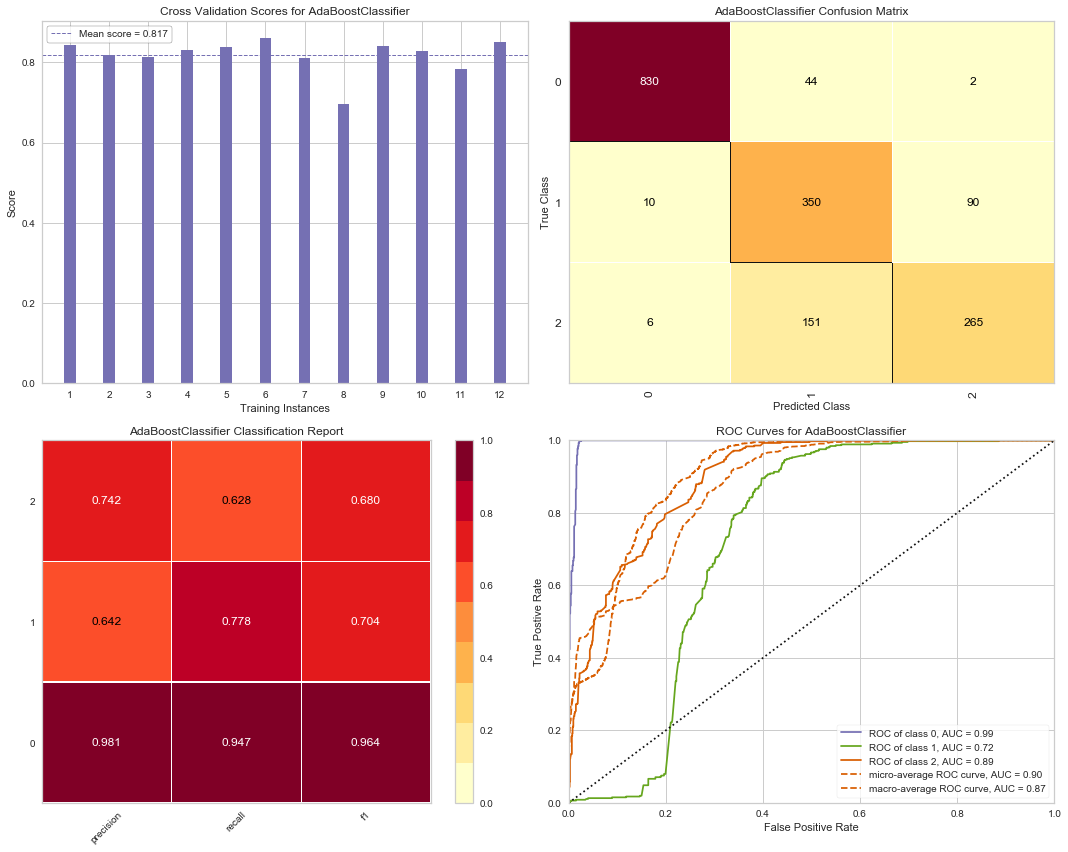

In [29]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(adac,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(adac, ax=axes[0][1]),
    ybc.ClassificationReport(adac, ax=axes[1][0]),
    ybc.ROCAUC(adac, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

# Random Forest Classifier Model - Winner, Winner, Chicken Dinner

In [47]:
#Random Forest Classifier
rfc = RandomForestClassifier() #init
rfc.fit(X_train_scaled, y_train) #fit
preds = rfc.predict(X_test_scaled) #predict
proba_preds = rfc.predict_proba(X_test_scaled) #predict

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


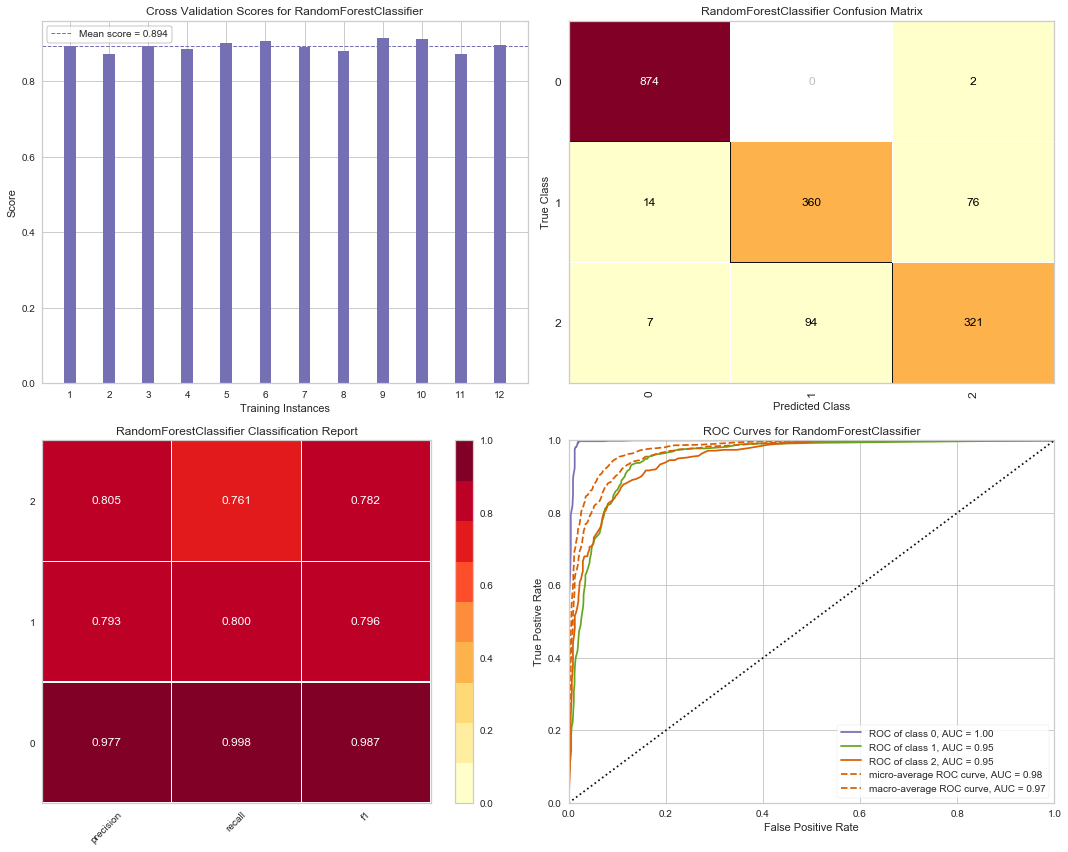

In [48]:
cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(rfc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(rfc, ax=axes[0][1]),
    ybc.ClassificationReport(rfc, ax=axes[1][0]),
    ybc.ROCAUC(rfc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test_scaled, y_test)
    viz.finalize()

plt.show()

# Parameter Evaluation

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


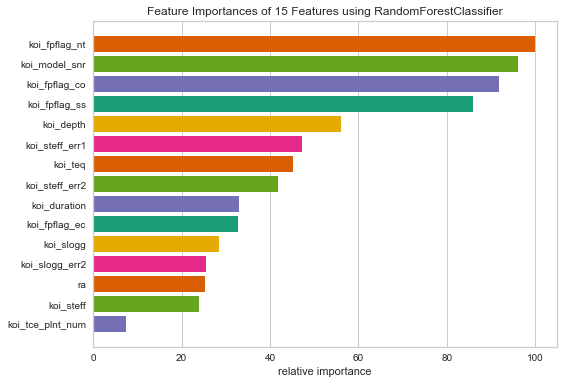

In [50]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(rfc, labels=select_features)
viz.fit(X_train_scaled, y_train)
viz.score(X_test_scaled, y_test)
viz.finalize()

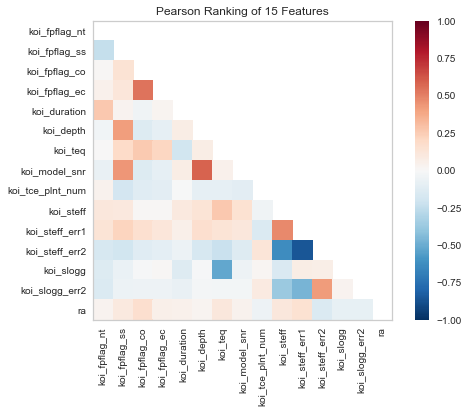

In [59]:
from yellowbrick.features import Rank2D
# Instantiate the visualizer with the Pearson ranking algorithm
ranking = Rank2D(features=select_features, algorithm='pearson')
ranking.fit(X_train_scaled, y_train)                
ranking.transform(X_train_scaled)             
ranking.poof()

# Re-do the Processing with Fewer Parameters - This Doesn't Help

In [80]:
X2 = df[['koi_fpflag_nt','koi_model_snr', 'koi_fpflag_co','koi_depth', 'koi_fpflag_ss', 'koi_steff_err1', 'ra']]
y2 = df.label

In [81]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=17, stratify=y2) #stratify for unequal target weights

In [82]:
X_scaler2 = StandardScaler().fit(X_train2)
X_train_scaled2 = X_scaler2.transform(X_train2)
X_test_scaled2 = X_scaler2.transform(X_test2)

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


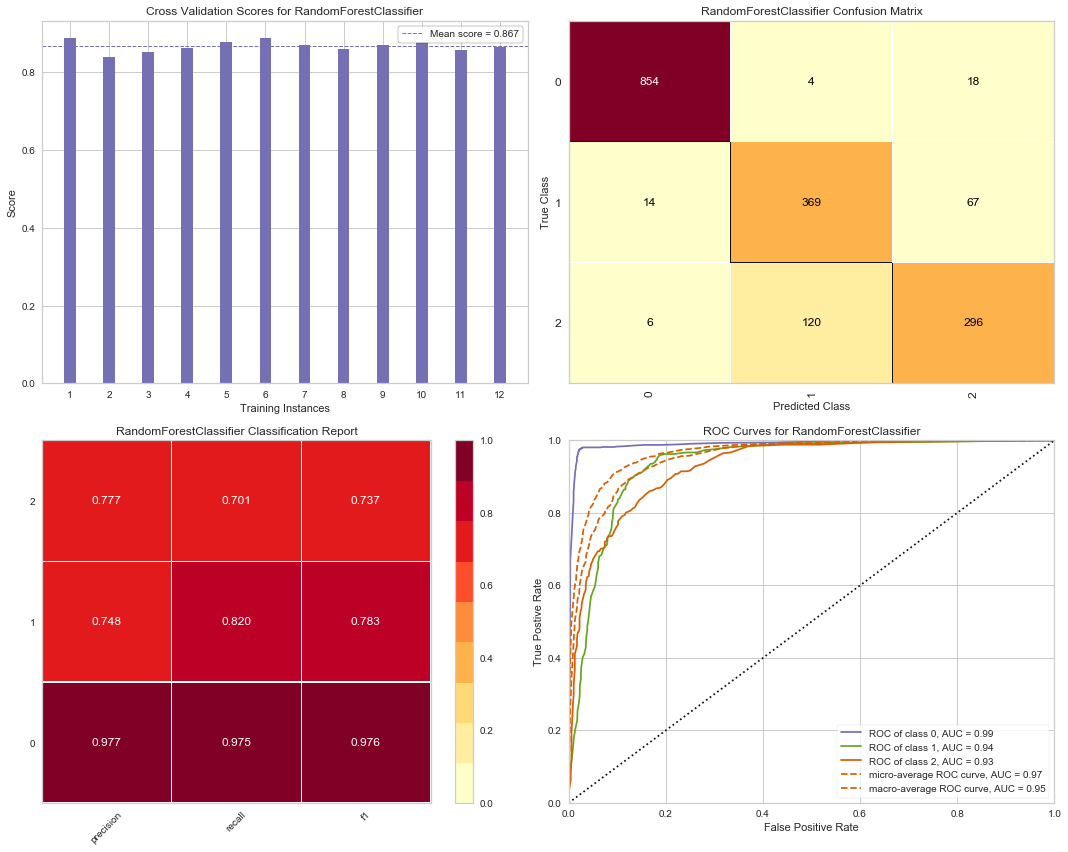

In [83]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled2, y_train2) #fit

cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(rfc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(rfc, ax=axes[0][1]),
    ybc.ClassificationReport(rfc, ax=axes[1][0]),
    ybc.ROCAUC(rfc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train2, y_train2)
    viz.score(X_test_scaled2, y_test2)
    viz.finalize()

plt.show()

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


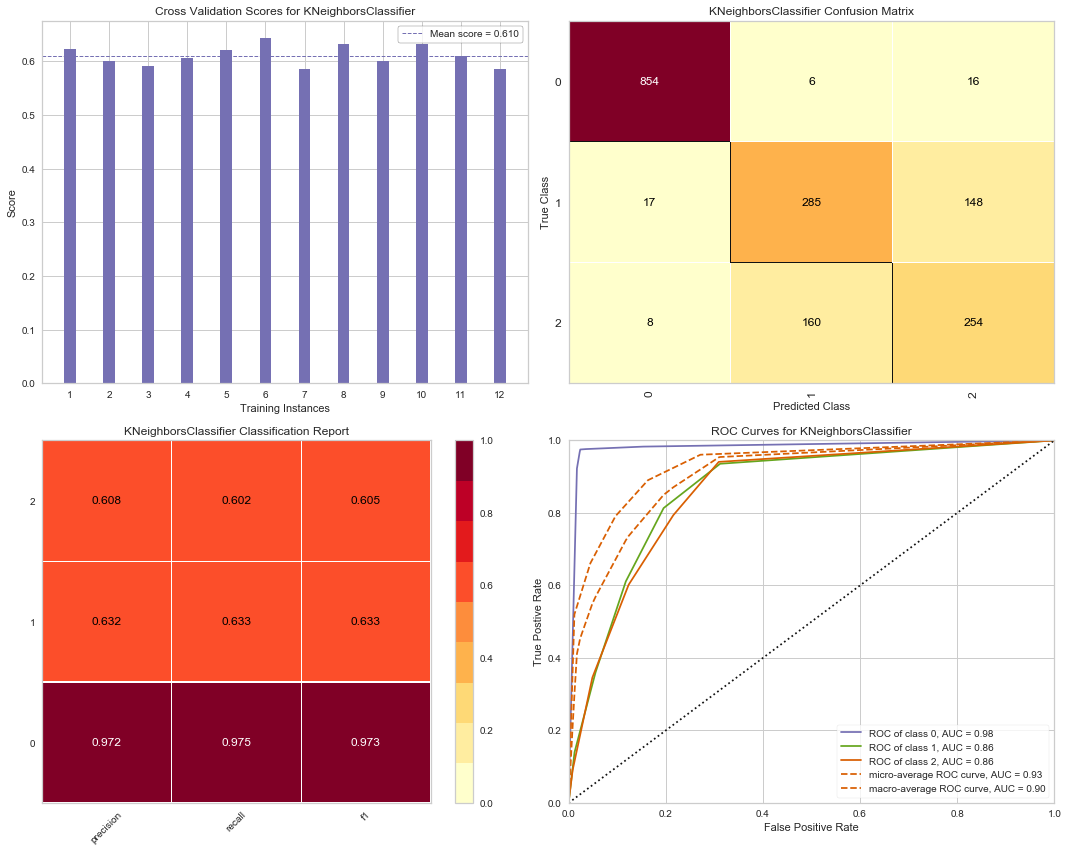

In [84]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled2, y_train2)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(knn,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(knn, ax=axes[0][1]),
    ybc.ClassificationReport(knn, ax=axes[1][0]),
    ybc.ROCAUC(knn, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train2, y_train2)
    viz.score(X_test_scaled2, y_test2)
    viz.finalize()

plt.show()

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


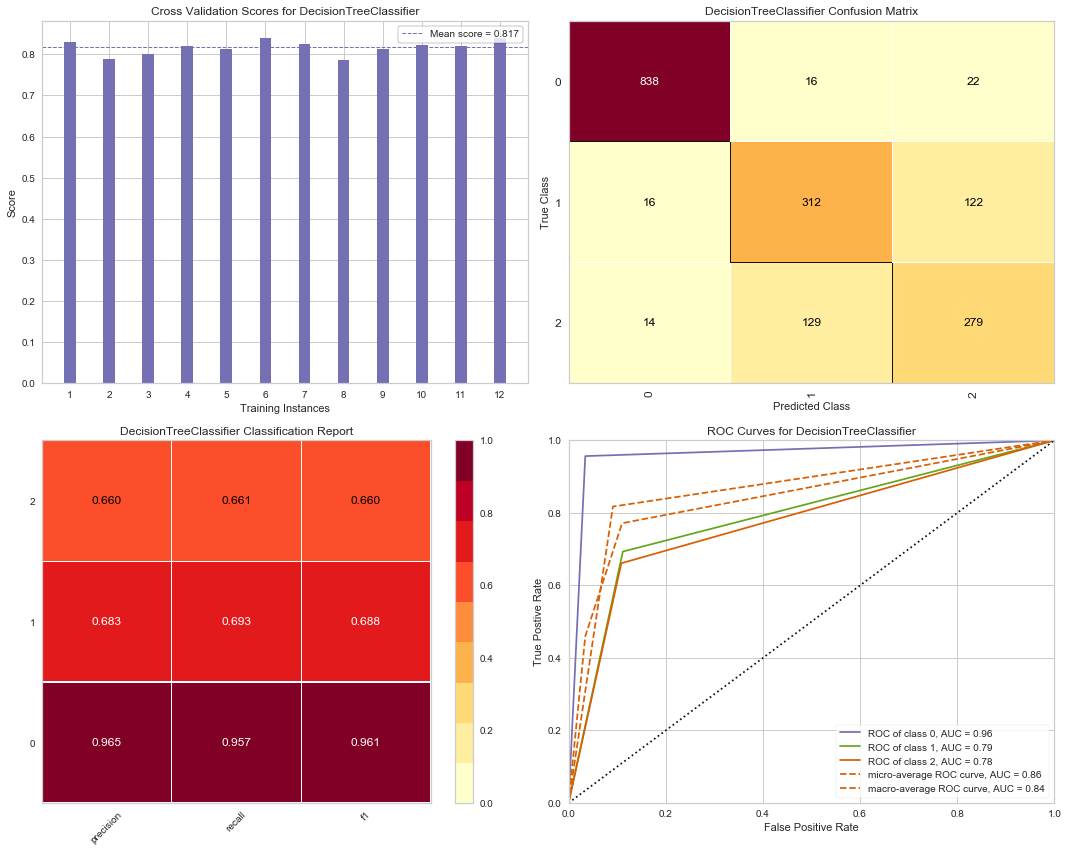

In [86]:
dtc = DecisionTreeClassifier() #init
dtc.fit(X_train_scaled2, y_train2) #fit

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(dtc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(dtc, ax=axes[0][1]),
    ybc.ClassificationReport(dtc, ax=axes[1][0]),
    ybc.ROCAUC(dtc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train2, y_train2)
    viz.score(X_test_scaled2, y_test2)
    viz.finalize()

plt.show()

/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


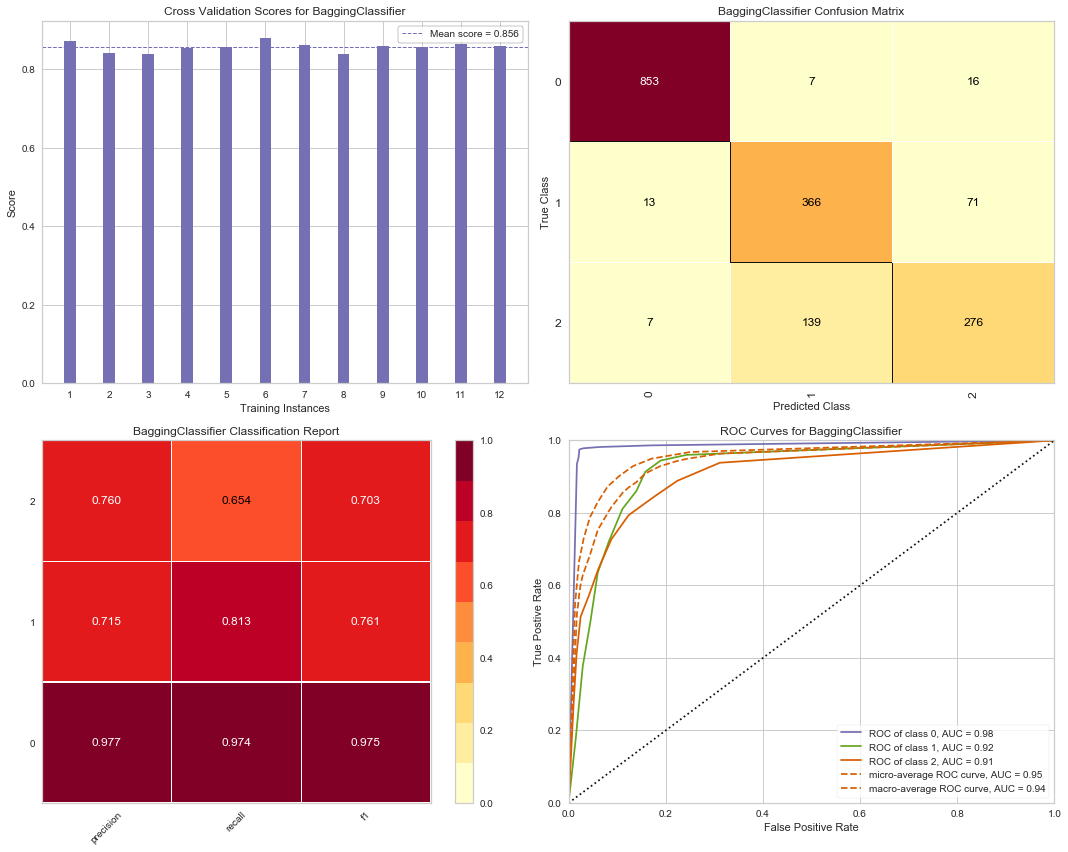

In [87]:
bagc = BaggingClassifier() #init
bagc.fit(X_train_scaled2, y_train2) #fit

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(bagc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(bagc, ax=axes[0][1]),
    ybc.ClassificationReport(bagc, ax=axes[1][0]),
    ybc.ROCAUC(bagc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train2, y_train2)
    viz.score(X_test_scaled2, y_test2)
    viz.finalize()

plt.show()

# Model Selection and Implementation

In [88]:
#SCALE on all the data
X_scaler_prod = StandardScaler().fit(X)
X_scaled_prod = X_scaler_prod.transform(X)


/Users/tkolencherry/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


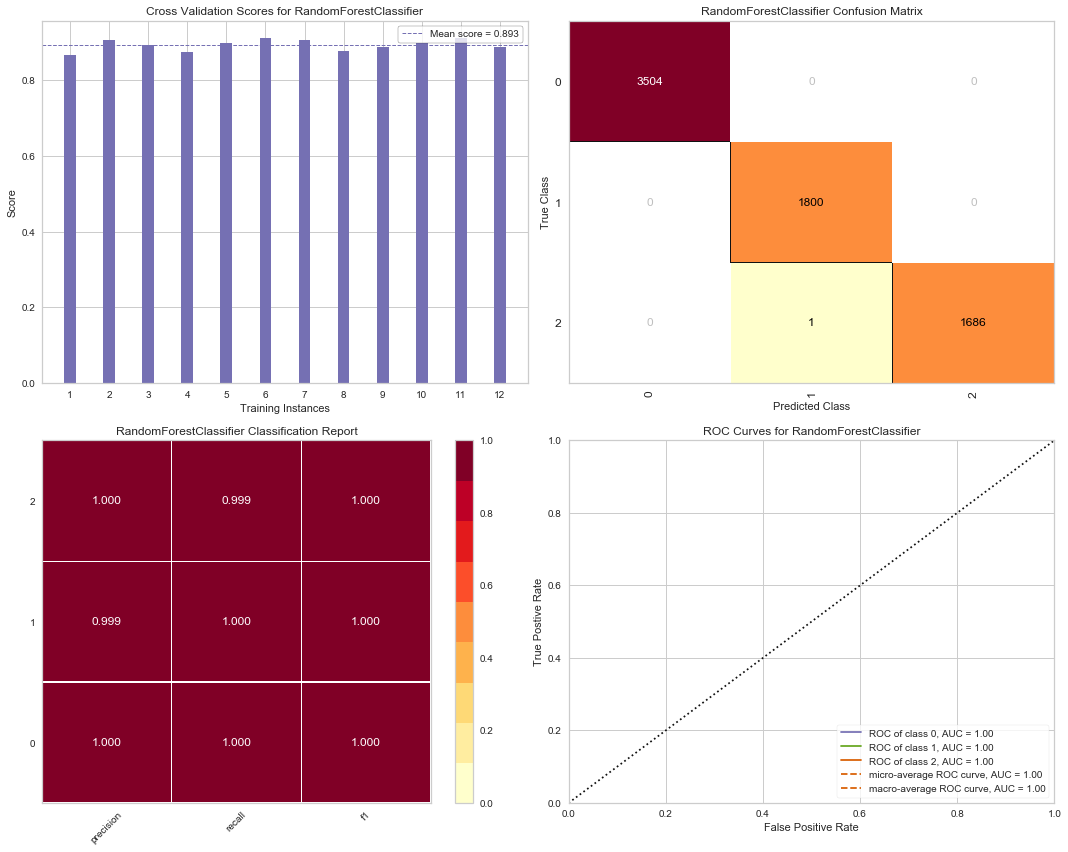

In [89]:
#Random Forest Classifier
rfc = RandomForestClassifier() #init
rfc.fit(X_scaled_prod, y.values.ravel()) #fit
preds = rfc.predict(X_scaled_prod) #predict
proba_preds = rfc.predict_proba(X_scaled_prod) #predict

cv = StratifiedKFold(n_splits=12, random_state=17, shuffle = True)

fig, axes = plt.subplots(2, 2, figsize=(15,12))

visualgrid = [
    CVScores(rfc,cv=cv,ax=axes[0][0]),
    ybc.ConfusionMatrix(rfc, ax=axes[0][1]),
    ybc.ClassificationReport(rfc, ax=axes[1][0]),
    ybc.ROCAUC(rfc, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_scaled_prod, y.values.ravel())
    viz.score(X_scaled_prod, y.values.ravel())
    viz.finalize()

plt.show()

In [90]:
#save the scaler
filename = 'finalized_scaler.sav'
pickle.dump(X_scaler_prod, open(filename, 'wb'))

In [91]:
#save the model
filename = 'finalized_model.sav'
pickle.dump(bagc, open(filename, 'wb'))